## 선형회귀(Linear Regression)
- 사실 AI 시대에 통계학 배울 때의 '회귀분석'을 생각하면 안 될 것 같다.
  - '스파르타코딩클럽' 뿐만 아니라 많은 곳에서 회귀분석 설명하면서 정규방정식도 언급하지만 경사하강법을 설명하더라.

### 01 라이브러리, 하이퍼파라미터

#### 01-01 데이터 로드 및 라이브러리

In [ ]:
import torch # 머신러닝, 딥러닝에 활용되는 라이브러리
import numpy as np # numpy 라이브러리(수식)
import pandas as pd # pandas 라이브러리(데이터프레임)
import matplotlib.pyplot as plt # 시각화 라이브러리

from torch import nn # neural net? 신경망?
from sklearn.datasets import fetch_california_housing # sklearn에 내장된 california_housing 데이터를 불러온다?
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import model_selection

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
regression_data_info = fetch_california_housing()

In [ ]:
regression_data_info # data는 x값을 array로, target은 y값이 array로

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [ ]:
regression_data_info.feature_names # 변수명 확인

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

#### 01-02 학습조건 설정
- epochs = 200 : 학습 주기(횟수) 200회
- learning_rate : 학습률(작을수록 학습할 때마다 x축 상에서 작게 이동)
- colab에서 가속모드 사용안했기에 device는 cpu나옴(보통 메모리 12GB정도 됨)
  - 25년 7월 기준 대한민국에서는 colab pro, colab pro+ 을 '정식'으로 구독할 방법 없음

In [ ]:
regression_feature_names = regression_data_info.feature_names # 그래서 강의 교안 코드에 .feature_names를 표시

num_samples = 100
test_data_ratio = 0.3 # test data 비율 30%, train data 비율 70%

random_state = 0 # random_state 설정(재현성 위해서)
polynomial_degree = 1 # 1차식(선형 회귀이므로)

epochs = 200
learning_rate = 5e-2  # 5e-2= (0.05), 1e-5, 5e-5, 1e-4, 5-e4, 1e-3, 5e-3, 1e-2, 5e-2

criterion = torch.nn.MSELoss()

print("device: {}".format(device))

device: cpu


#### 01-03 (참고) sin 함수 확인?
- (-1.57079632679, 1.57079632679)안에 속하는 sin함수는?

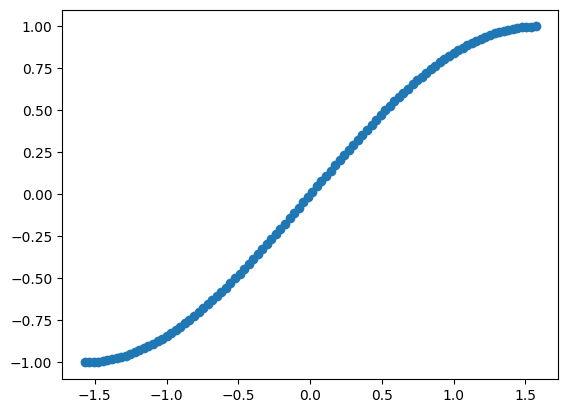

In [ ]:
data = np.linspace(-np.pi/2, np.pi/2, num_samples).reshape(num_samples,1)

label = np.sin(data)

idx = np.random.permutation(num_samples)

data = data[idx]
label = label[idx]

plt.scatter(data, label)
plt.show()

#### 01-03 Califnoia Dataset 일부 확인


In [ ]:
california_df = pd.DataFrame(regression_data_info.data, columns=regression_feature_names) # column-name은 feature_name
california_df['label'] = regression_data_info.target # y값은 target

california_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,label
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 02 여러 함수 정의
- 데이터 로드 하고 시각화 하는 과정에서의 여러 함수들 정의

#### 02-01 데이터 로드, 시각화 함수 정의

In [ ]:
class SimpleDataLoader:
  def __init__(self, num_samples, test_data_ratio):
        self.num_samples = num_samples
        self.test_data_ratio = test_data_ratio

        self.data, self.label = self.get_dataset()
        self.train_data, self.train_label, self.test_data, self.test_label = (self.get_split_data())

        # self.standardize_data()
        self.min_max_normalize_data()

  def __call__(self, flag):
    if flag == 'train':
        return self.train_data, self.train_label
    else:
        return self.test_data, self.test_label

  def get_dataset(self):
    data = np.linspace(-np.pi/2, np.pi/2, self.num_samples).reshape(self.num_samples, 1)
    label = np.sin(data)

    idx = np.random.permutation(self.num_samples)

    data = data[idx]
    label = label[idx]

    return data, label

  def get_split_data(self):
    num_train_data = int(self.num_samples*(1-self.test_data_ratio))

    train_data, train_label = self.data[:num_train_data], self.label[:num_train_data]
    test_data, test_label = self.data[num_train_data:], self.label[num_train_data:]

    return train_data, train_label, test_data, test_label

  def standardize_data(self):
    mean = np.mean(self.train_data, axis=0)
    std = np.std(self.train_data, axis=0)

    self.train_data = (self.train_data - mean) / std
    self.test_data = (self.test_data - mean) / std

  def min_max_normalize_data(self):
    min = np.min(self.train_data, axis=0)
    max = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min) / (max - min)
    self.test_data = (self.test_data - min) / (max - min)


class MultipleDataLoader:
  def __init__(self, data_info, feature_names, test_data_ratio, random_state):
    self.data_info = data_info
    self.feature_names = feature_names
    self.test_data_ratio = test_data_ratio
    self.random_state = random_state

    self.data_infos = self.get_data_infos()
    self.data, self.label = self.get_dataset()

    self.train_data, self.train_label, self.test_data, self.test_label = (self.get_split_data())
    self.standardize_data()
    # self.min_max_normalize_data()


  def __call__(self, flag):
    if flag == 'train':
        return self.train_data, self.train_label
    else:
        return self.test_data, self.test_label

  def get_data_infos(self):
    df = pd.DataFrame(self.data_info.data, columns=self.feature_names)
    df['label'] = self.data_info.target

    return df

  def get_dataset(self):
    data, label = self.data_infos.drop(columns=['label']), self.data_infos['label']

    return data, label

  def get_split_data(self):
    train_data, test_data, train_label, test_label = model_selection.train_test_split(
        self.data, self.label, test_size=self.test_data_ratio, random_state = self.random_state
    )
    return train_data.to_numpy(), train_label.to_numpy(), test_data.to_numpy(), test_label.to_numpy()

  def standardize_data(self):
    mean = np.mean(self.train_data, axis=0)
    std = np.std(self.train_data, axis=0)

    self.train_data = (self.train_data - mean) / std
    self.test_data = (self.test_data - mean) / std

  def min_max_normalize_data(self):
    min = np.min(self.train_data, axis=0)
    max = np.max(self.train_data, axis=0)

    self.train_data = (self.train_data - min) / (max - min)
    self.test_data = (self.test_data - min) / (max - min)


class DataProcessor:
  def __init__(self, polynomial_degree):
    self.polynomial_degree = polynomial_degree

  def __call__(self, data):
    num_samples = data.shape[0]

    bias_term = np.ones(num_samples).reshape(-1, 1)
    concat_data = bias_term

    for i in range(1, self.polynomial_degree + 1):
        concat_data = np.concatenate((concat_data, np.power(data, i)), axis=1)

    return concat_data

simple_dataloader = SimpleDataLoader(num_samples, test_data_ratio)
data_processor = DataProcessor(polynomial_degree)

simple_train_data, simple_train_label = simple_dataloader('train')
simple_test_data, simple_test_label = simple_dataloader('test')

simple_concat_train_data = data_processor(simple_train_data)
simple_concat_test_data = data_processor(simple_test_data)

multiple_dataloader = MultipleDataLoader(regression_data_info, regression_feature_names, test_data_ratio, random_state)
multiple_train_data, multiple_train_label = multiple_dataloader('train')
multiple_test_data, multiple_test_label = multiple_dataloader('test')

multiple_concat_train_data = data_processor(multiple_train_data)
multiple_concat_test_data = data_processor(multiple_test_data)

print('simple concat train data: {}/simple concat train label: {}'.format(simple_concat_train_data.shape, simple_train_label.shape))
print('simple concat test data: {}/simple concat test label: {}'.format(simple_concat_test_data.shape, simple_test_label.shape))

print('multiple concat train data: {}/multiple concat train label: {}'.format(multiple_concat_train_data.shape, multiple_train_label.shape))
print('multiple concat test data: {}/multiple concat test label: {}'.format(multiple_concat_test_data.shape, multiple_test_label.shape))

simple concat train data: (70, 2)/simple concat train label: (70, 1)
simple concat test data: (30, 2)/simple concat test label: (30, 1)
multiple concat train data: (14448, 9)/multiple concat train label: (14448,)
multiple concat test data: (6192, 9)/multiple concat test label: (6192,)


#### 02-02 Regression 정의

In [ ]:
class TorchLinearRegression(nn.Module):
  def __init__(self, data):
    super(TorchLinearRegression, self).__init__()
    self.regressor = nn.Linear(data.shape[1], 1, bias=False)

  def forward(self, data):
    result = self.regressor(data)

    return result

  def get_params(self):
    param_list = list(self.regressor.parameters())

    weight = param_list[0][0, 1:].cpu().detach().numpy()
    bias = param_list[0][0, 0].cpu().detach().numpy()

    return weight, bias

class NumpyLinearRegression:
  def __init__(self):
    self.parameters = None

  def __call__(self, data):
    pred = data @ self.parameters

    return pred

  def get_params(self):
    np_weight, np_bias = self.parameters[1:], self.parameters[0]

    return np_weight, np_bias


simple_np_regressor = NumpyLinearRegression()

simple_torch_regressor = TorchLinearRegression(simple_concat_train_data).to(device)
simple_torch_model_optimizer = torch.optim.SGD(simple_torch_regressor.parameters(), lr =learning_rate)

multiple_np_regressor = NumpyLinearRegression()

multiple_torch_regressor = TorchLinearRegression(multiple_concat_train_data).to(device)
multiple_torch_model_optimizer = torch.optim.SGD(multiple_torch_regressor.parameters(), lr =learning_rate)


### 03 Regression 학습

#### 03-01 Regression 정의
- numpy
- torch

In [ ]:
def train_numpy_model(data, label, model):
  model.parameters = np.linalg.inv(data.T @ data) @ data.T @ label   # θ = (XᵀX)⁻¹Xᵀy


def train_torch_model(data, label, model, criterion, optimizer, epochs, device):
  model.train()

  data, label = torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(
    label, dtype=torch.float32
  ).to(device)

  for epoch in range(epochs):
    optimizer.zero_grad()
    result = model(data)

    label = label.reshape(label.shape[0], 1)
    loss = criterion(result, label)

    loss.backward()
    optimizer.step()


train_numpy_model(simple_concat_train_data, simple_train_label, simple_np_regressor)
train_torch_model(simple_concat_train_data, simple_train_label, simple_torch_regressor, criterion, simple_torch_model_optimizer, epochs, device)

train_numpy_model(multiple_concat_train_data, multiple_train_label, multiple_np_regressor)
train_torch_model(multiple_concat_train_data, multiple_train_label, multiple_torch_regressor, criterion, multiple_torch_model_optimizer, epochs, device)

#### 03-02 파라미터 시각화

In [ ]:
def show_parameters(np_model, torch_model):
  np_weight, np_bias = np_model.get_params()

  torch_weight, torch_bias = torch_model.get_params()

  print('np weight : {}\n torch_weight : {}'.format(np_weight,torch_weight))
  print('np bias : {}#n torch_weight: {}'.format(np_bias, torch_bias))

show_parameters(simple_np_regressor, simple_torch_regressor)
show_parameters(multiple_np_regressor, multiple_torch_regressor)

np weight : [[2.38941612]]
 torch_weight : [2.2598495]
np bias : [-1.19396489]#n torch_weight: -1.1233936548233032
np weight : [ 0.84489085  0.1156853  -0.27019687  0.29078838 -0.0107715  -0.02805796
 -0.8753289  -0.84959869]
 torch_weight : [ 0.8756375   0.12564608 -0.3166045   0.3241511  -0.00753823 -0.02915483
 -0.77161306 -0.74897003]
np bias : 2.0682462451550454#n torch_weight: 2.0682451725006104


#### 04 모델 테스트하기

In [ ]:
def test_model(data, label, model):
  result = model(data)

  mae = mean_absolute_error(label, result) # label은 정답지, result는 예측된 값
  mse = mean_squared_error(label, result) # label은 정답지, result는 예측된 값

  print('np model MAE: {}, RMSE: {}'.format(mae, np.sqrt(mse)))

def test_torch_model(data, label, model, device):
  model.eval()

  data, label = torch.tensor(data, dtype=torch.float32).to(device), torch.tensor(label, dtype=torch.float32).to(device)

  with torch.no_grad():
    result = model(data)

    mae = mean_absolute_error(label.cpu().detach().numpy(), result.cpu().detach().numpy())
    mse = mean_squared_error(label.cpu().detach().numpy(), result.cpu().detach().numpy())

    print('torch model MAE: {}, RMSE: {}'.format(mae, np.sqrt(mse)))

test_model(simple_concat_test_data, simple_test_label, simple_np_regressor)
test_torch_model(simple_concat_test_data, simple_test_label, simple_torch_regressor, device)

test_model(multiple_concat_test_data, multiple_test_label, multiple_np_regressor)
test_torch_model(multiple_concat_test_data, multiple_test_label, multiple_torch_regressor, device)

np model MAE: 0.07834347321726536, RMSE: 0.08669087913613559
torch model MAE: 0.09466223418712616, RMSE: 0.10387584252107612
np model MAE: 0.5361818140641845, RMSE: 0.7369864089681191
torch model MAE: 0.535868227481842, RMSE: 0.7396408560147488
